## The Representation of Women in Film -- A Data Science Tutorial by Michelle Badalov 

Women's presence in the performing arts dates back to the early 1660s, however the history of theater goes as far back as 532 BC when the Greeks began putting on tragedies. 'What is the reason for this temporal gap?' one might ask. Well, women were not allowed on the stage for many centuries because it was considered "dangerous". In fact, men were responsible for portraying both male and female characters all that time (NC Theatre, 2015). Fast forward to 2022, and we see that women are still not offered equal opportunity in the performing arts. 

It is no question that the representation of women in film is deeply flawed and biased. Despite the fact that half of the world is comprised of women, an overwhelming amount of films lack female roles and even fewer accurately portray the female experience. 

An interesting measure of this representation uses the Bechdel Test (BT). This test was coined by Alison Bechdel's comic in a 1985 strip called 'The Rule'. For more information on its origin, one can find an insightful introduction to the comic on feministfrequency.com.

<img src="BechdelComic.jpeg" width="500" height="340">

According to the comic, to pass the Bechdel Test, a film must satisfy three criteria:

1. The film has at least two women in it, 
2. the women in the film must speak to each other at least once, 
3. the conversation between the women must be about something besides men.

Seems easy enough, right? We will explore just how simple an expectation this is throughout the tutorial. 

Specifically, I will be investigating three questions:

1. How many films pass the Bechdel test per year? 
2. How has this ratio changed over time?
3. How do films passing the Bechdel Test perform in comparison to those who don't?

By the end of this tutorial, I hope to gain perspective  on the reality of female representation in film, as well as the public perception of female representation in film. 

### Step 1
#### Data collection/curation + parsing

http://Bechdeltest.com provides an up-to-date and easy to access list of movies that do or don't pass the test. On the website, there is a link to add new movies and one can suggest a re-rating of a movie by leaving a comment on the movie page. Using the API (documentation can be found at https://bechdeltest.com/api/v1/doc) one can query the list. All calls will look like http://bechdeltest.com/api/v1/method?params where the methods and necessary parameters are given in the documentation. 

The website provides four methods to query the list: getMovieByimdbId, getMoviesByTitle, getAllMovieIds, getAllMovies. I will be using getAllMovies as I will be working with the all of the features. The query returns a JSON object containing the following information about each movie: year, rating, title, ID, and imdb ID.

Thus, I can use Python's requests and json modules to extract the object. Using pandas, I can then store the JSON contents in a dataframe. 

More on this technique can be found at https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8.

In [508]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter     
import statsmodels.api as sm


# requests data for all movies in list
response_API = requests.get('https://bechdeltest.com/api/v1/getAllMovies?')

# accesses text of response
data = response_API.text

# loads data into json format
json = json.loads(data)

# converts json into dataframe
df_BT = pd.DataFrame(json)
   
df_BT.head()

,rating,year,imdbid,id,title
0,0,1874,3155794,9602,Passage de Venus
1,0,1877,14495706,9804,La Rosace Magique
2,0,1878,2221420,9603,Sallie Gardner at a Gallop
3,0,1878,12592084,9806,Le singe musicien
4,0,1881,7816420,9816,Athlete Swinging a Pick


In order to address my third question, 'How do films passing the Bechdel Test perform in comparison to those who don't?', I need access to a dataset containing profits of all the movies. 

After an extensive search for such a dataset, Kaggle proved to be a great resource. The Movies Dataset (https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download) provided by Rounak Bounik provides metadata on over 45,000 movies listed in the MovieLens dataset (https://grouplens.org/datasets/movielens/), as well as 26 million ratings from over 270,000 users. It is important to note that this dataset only contains movies released on or before July 2017, so I will have to filter accordingly. 

The main Movies Metadata file contains posters, backdrops, budget, revenue, release dates, languages, production countries and companies on these movies. For this tutorial, I am only interested in imdb IDs, titles, release date, and revenues. 

One can quickly download this dataset as a CSV file from the website . From here is it easy to use Python's Pandas module to store the data in a dataframe.

More on this technique can be found at https://www.geeksforgeeks.org/python-read-csv-using-pandas-read_csv/. 

In [509]:
# reads in csv containing performance data 
df_per = pd.read_csv('movies_metadata.csv', usecols= ['imdb_id', 'title', 'release_date', 'revenue'])

df_per.head()

,imdb_id,release_date,revenue,title
0,tt0114709,1995-10-30,373554033.0,Toy Story
1,tt0113497,1995-12-15,262797249.0,Jumanji
2,tt0113228,1995-12-22,0.0,Grumpier Old Men
3,tt0114885,1995-12-22,81452156.0,Waiting to Exhale
4,tt0113041,1995-02-10,76578911.0,Father of the Bride Part II


### Step 2
#### Data Management and Representation

It is important to prepare and tidy datasets so that they can be used to perform data analysis with ease. Currently, both dataframes consist of thousands of rows. We will see throughout this step that not all rows will be useable for either dataset. 

My first question, 'How many films pass the Bechdel test per year?', requires the computation of ratios of BT passing films to total films for each year. Thus, I need to separate the dataset by year and then compute the number of films that received a score of 3 on the BT. Dividing this number by the total number of films released for the year will return the ratio I am looking for. 

Further, I will be filtering out any movies released before the 21st century as most of those movies received a 0 on the BT and I would like my findings to be current. 

More on filtering based on conditions can be found at https://www.geeksforgeeks.org/selecting-rows-in-pandas-dataframe-based-on-conditions/. 

More on grouping dataframes can be found at https://realpython.com/pandas-groupby/. 

In [510]:
# lists to store necessary components of entire dataframe:

# list of all present years
years = []

# list of total number of films released per year 
total = []

# list of number of BT-passing films released per year 
passed = []

# list of computed ratios per year
ratios = []

# dataframe to visualize all the previous lists 
ratios_df = pd.DataFrame()

# filters out movies released before 21st century 
df_BT = df_BT[df_BT['year'] >= 2000]


# computes ratio of films which passed Bechdel Test per year 
# stores years, ratios, total number of films, and number of films which passed Bechdel test (rating = 3) in respective lists 
for name, group in df_BT.groupby('year'):
    tot_pass = len(group[(group['rating']==3)])
    tot_len = len(group['rating'])
    years.append(name)
    ratios.append(tot_pass/tot_len)
    total.append(tot_len)
    passed.append(tot_pass)


# combines data into one dataframe 
ratios_df['Year'] = years
ratios_df['Passed Films (P)'] = passed
ratios_df['Total Films (T)'] = total
ratios_df['Ratio (P/T)'] = ratios

ratios_df.head()

,Year,Passed Films (P),Total Films (T),Ratio (P/T)
0,2000,96,157,0.611465
1,2001,112,179,0.625698
2,2002,106,191,0.554974
3,2003,104,173,0.601156
4,2004,127,206,0.616505


Here, we can observe the frequency of all films, BT passing films, and the ratio. 

Next, I need to adequately prepare the dataset containing movie revenues and ratings.

Observe that the 'year' column of the BT dataset contains only the year (YYYY) that the film was released whereas the performance dataset has the full release date (YYYY-MM-DD). Further, the performance dataset has the imdb IDs listed with 'tt' prefixed. I need to adjust the datasets as necessary so that these columns have matching formats. Otherwise, it will be very difficult to compare the same movies/years. 

More on string slicing can be found at https://www.w3schools.com/python/gloss_python_string_slice.asp. 

In [511]:
# modifies dates to only show years and imdb ID's to match format of performance DF
df_per['release_date'] = df_per['release_date'].str[:4]
df_per['imdb_id'] = df_per['imdb_id'].str[2:]

It is crucial to handle missing data accordingly. Empty or missing values might skew data and/or raise errors. First, I replace empty values in the imdb column with NaN. I then drop any rows in both datasets containing Nan values.

More on handling missing data can be found at https://machinelearningmastery.com/handle-missing-data-python/. 

Once again, for the performance dataset I filter out movies before the 21st century. 

In [512]:
# gets rid of all empty values 
df_BT['imdbid'].replace('', np.nan, inplace=True)
df_per['imdb_id'].replace('', np.nan, inplace=True)

df_BT = df_BT.dropna()
df_per = df_per.dropna()

# filters out movies before 21st century 
df_per['year'] = df_per['release_date'].astype(int)
df_per = df_per[df_per['year'] >= 2000]

In order to visualize how movies perform based on BT score, I need to append the revenue column to our BT dataset. This proved to be a bit difficult. 

I first found the intersection of the two imdb ID columns and filtered out the movies in either dataset that were not contained in this intersection. However, the new imdb ID columns were still not identical (or even of the same length) so I hoped duplicate rows were the issue. While dropping duplicates solved the problem for the revenue data, the Bechdel data was still not identical. 

More on using np.intersect1d can be found at https://numpy.org/doc/stable/reference/generated/numpy.intersect1d.html. 

Note that I also sort the columns by imdb IDs so that I can later combine the datasets on this index. 

In [513]:
# finds intersection of movies in lists 
movie_ids = np.intersect1d(df_BT['imdbid'], df_per['imdb_id'], assume_unique=False, return_indices=False)

# filters out movies that are not contained in the intersection and sorts values by imdb ID
df_per = (df_per.loc[df_per['imdb_id'].isin(movie_ids)]).sort_values(by=['imdb_id'])
df_BT = (df_BT.loc[df_BT['imdbid'].isin(df_per['imdb_id'])]).sort_values(by=['imdbid'])

df_BT = df_BT.drop_duplicates()
df_per = df_per.drop_duplicates()


print(len(df_BT['imdbid']) == len(df_per['imdb_id']))

False


I realized after some thought that it was possible that the BT dataset contained duplicate imdb ID's but because the entire rows were not exactly the same, drop_duplicates() was not catching those. So, I decided the simplest solution would be to manually find the rows containing imdb ID duplicates and drop them. 

In [514]:
# list of see indices 
list_ids = []

# if an ID has already been seen, I print the index  
# if an ID has not been seen, I add the ID to list_ids
for index, row in df_BT.iterrows():
    if row['imdbid'] in list_ids:
        print(index)
    else:
        list_ids.append(row['imdbid'])

6517
7167


In [515]:
# drop rows containing duplicate IDs
df_BT = df_BT.drop(index = [6517, 7167])

I am almost complete with the data processing. 

Next, I append the revenue column to my BT dataset.

In [516]:
# reset to 0-indexing so indices between the two dfs match to avoid errors. 
df_BT.reset_index(drop=True)
df_per.reset_index(drop=True)

df_BT['revenue'] = df_per['revenue']

To confirm that the revenue matches with the correct imdb ID, I need to make sure that the imdb ID columns are actually identical. Python's Numpy module has a handy function (numpy.array_equal) to assure this.

In [517]:
# access imdb ID columns and ensures both are of the same type for comparison
d1 = df_BT['imdbid'].astype(int).to_numpy()
d2 = df_per['imdb_id'].astype(int).to_numpy()

# compares arrays 
print(np.array_equal(d1, d2))

True


Now, we can compute the average film revenue for each BT rating. 

In [518]:
# list to store average revenues per rating
avg_rev = []

# splits BT dataframe by rating, computes average revenue, appends to avg_rev
for name, group in df_BT.groupby('rating'):
    avg_rev.append(group['revenue'].mean())

print(avg_rev)

[108407717.375, 109120133.6124031, 97028011.38095239, 94366508.82335329]


### Step 3
#### Exploratory data analysis

In this step, I will visualize the questions I highlighted in the introduction, and will perform data analysis to come to answers.  

In order to visualize my first question, 'How many films pass the Bechdel test per year?', I will plot the frequency of all films and films which passed the BT in a bar graph. While this comparison can be made using many different types of plots, bar graphs are primarily used for comparisons between groups, particularly  over time (NCES, 2022). Thus, I concluded that a bar graph would best communicate how these frequencies compare. 

More on grouped box charts can be found at https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py. 

Text(0.5, 1.0, 'Number of Films that Passed Bechdel Test Compared to Total Number of Films Per Year')

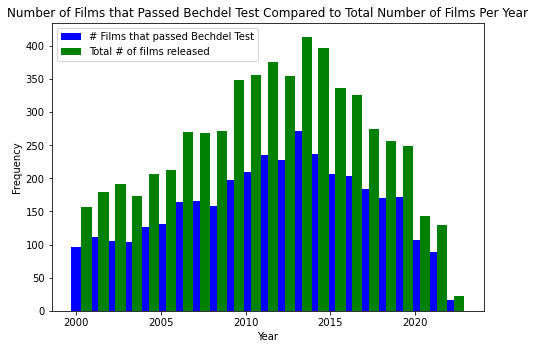

In [519]:
# creates a two-variable bar plot which visualizes how often films have passed the 
# Bechdel Test throughout the 21st century 
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# adds frequency of passed films and total films to plot 
ax.bar(ratios_df['Year'], ratios_df['Passed Films (P)'], color = 'b', width = 0.6)
ax.bar(ratios_df['Year'] + 0.6, ratios_df['Total Films (T)'], color = 'g', width = 0.6)

# necessary axis, legend, and title labels
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')

ax.legend(labels=['# Films that passed Bechdel Test', 'Total # of films released'])
ax.set_title('Number of Films that Passed Bechdel Test Compared to Total Number of Films Per Year')

As seen in this graph, the number of films which pass the Bechdel Test per year is consistently and significantly less than the total amount of films released. 

Now, I am interested in my second question, 'How has this ratio changed over time?', for which I will be making a scatter plot. Scatter plots are ideal for tracking smaller-scale changes over time (NCES, 2022). I can deduce from my raw data and the above bar graph that the ratios do not change dramatically over time, so a scatter plot is perfect for this scenario. Further, adding a line of best fit will best help address how the ratio has or has not improved over the 21st century. 

More on plotting lines of best fit can be found at https://www.statology.org/line-of-best-fit-python/. 

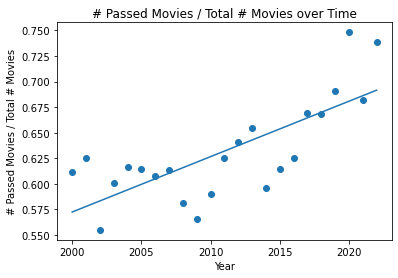

Average Ratio: 0.6320283175607141
Slope of Line of Best Fit: 0.005413905408588168


In [520]:
# stores x and y axis data 
x = ratios_df['Year']
y = ratios_df['Ratio (P/T)']

# finds line of best fit
m, b = np.polyfit(x, y, 1)

# creates scatter plot of ratio of movies passing test over time with line of best fit 
plt.scatter(x, y)

# adds line of best fit to plot
plt.plot(x, m*x+b)

# necessary labels 
plt.title("# Passed Movies / Total # Movies over Time")
plt.xlabel("Year")
plt.ylabel("# Passed Movies / Total # Movies")

plt.show()

# Prints the average ratio of films which passed Bechdel Test in 21st century 
print("Average Ratio: " + str(ratios_df['Ratio (P/T)'].mean()))

# Prints slope of line of best fit 
print("Slope of Line of Best Fit: " + str(m))

As seen above, the slope of the line of best fit is very small (< 0.006), supporting my previous statement that the ratios have not improved significantly over time. Furthermore, the ratios appear to be concentrated in the (0.6, 0.65) range, which is reinforced by the fact that the average ratio over the 21st century is approximately 0.632. 

However, despite the fact that the slope is small, it is still positive. This means that the amount of films passing the Bechdel Test in comparison to total released films per year is increasing -- a promising result for established and aspiring female actors. 

Now we will answer my third question, 'How do films passing the Bechdel Test perform in comparison to those who don't?'. 

In order to visualize this answer, I will again be making a box plot that will have each possible Bechdel Test score ([0, 1, 2, 3]) on the x-axis with the corresponding average revenue on the y-axis. Because there are so few values on the x-axis, I deduced that a box plot would again be the most efficient way to visualize this comparison. 

10485445.299431875


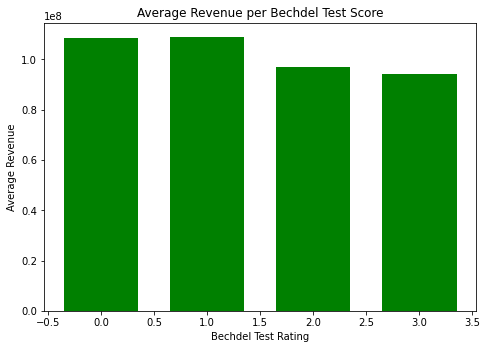

In [521]:
# creates box plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# plots corresponding average revenues to rating 
ax.bar([0, 1, 2, 3], avg_rev, color = 'g', width = 0.7)

# necessary labels 
ax.set_xlabel('Bechdel Test Rating')
ax.set_ylabel('Average Revenue')
ax.set_title('Average Revenue per Bechdel Test Score')

# prints difference of average revenue of non-BT-passing films and passing films. 
print(((avg_rev[0] +avg_rev[1] + avg_rev[2])/3)- avg_rev[3])


While the difference does not appear stark in this graph, it is clear that as a movie gets closer to passing the Bechdel Test, it draws in less revenue. 
In fact, as seen by my calculation, on average non BT passing (rating of < 3) movies earned roughly $10485445.30 more in revenue than movies who did pass. 

### Step 4 
#### Hypothesis testing... When will the gap close?

In this step, I will be revisiting my second question, 'How has this ratio changed over time?". Specifically, I want to predict when the ratio will be 1, meaning that all of the films released in a year will pass the Bechdel Test. 
However, if there does not exist a linear relationship between time and ratio, this will be difficult to calculate. We will confirm or deny the existence  of such a relationship through the use of hypothesis testing. 

My hypothesis will consist of the following:

##### Null Hypothesis: there does not exist a linear relationship between time and ratio. 
##### Alternate Hypothesis: there does exist a linear relationship between time and ratio. 


First, I would like to briefly revisit the scatter plot of ratios over time. Based on the line of best fit one might predict that there is in fact a linear relationship. But you can never be too sure. 

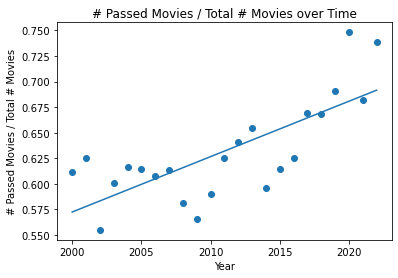

In [522]:
# creates scatter plot of ratio of movies passing test over time with line of best fit 
plt.scatter(x, y)

#add line of best fit to plot
plt.plot(x, m*x+b)

plt.title("# Passed Movies / Total # Movies over Time")
plt.xlabel("Year")
plt.ylabel("# Passed Movies / Total # Movies")

plt.show()

In order to test my hypothesis, I will be using Python's statsmodels.api module. statsmodels allows users to estimate many different statistical models and conduct statistical tests as well as data exploration. A user-friendly introduction can be found at https://www.statsmodels.org/stable/index.html.

Python provides many other tools for hypothesis testing as well such as scipy (https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/). However, I chose to work with this module because I am most familiar with it and I find it to be very easy to use, as will be exemplified below. 

Further, I am specifically using Ordinary Least Squares regression which is a common and simple technique for estimating linear regression models.  

More on this technique can be found at https://www.geeksforgeeks.org/ordinary-least-squares-ols-using-statsmodels/. 

In [523]:
# uses OLS to gather p values
fit = sm.OLS(y, x).fit()

# prints summary of linear model findings 
print(fit.summary())


                                 OLS Regression Results                                
Dep. Variable:            Ratio (P/T)   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              4033.
Date:                Mon, 16 May 2022   Prob (F-statistic):                    2.02e-26
Time:                        22:47:16   Log-Likelihood:                          37.841
No. Observations:                  23   AIC:                                     -73.68
Df Residuals:                      22   BIC:                                     -72.55
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Observe that the calculated p-value is 0. This implies that the null hypothesis is rejected and we can confidently say that there is a relationship between time and ratio of BT passing movies to all movies. Using this fact, we can estimate when the ratio will reach 1. 

Using Numpy's handy linalg.solve function, we can solve the question of when this ratio will reach 1, i.e. all movies pass the Bechdel Test. 

In [524]:
print(np.linalg.solve([[m]], [1-b]))

[2078.96788172]


According to this calculation, all movies released in or after 2079 will pass the Bechdel Test... a less promising result for established and aspiring actresses. 

### Step 5
#### Insights 

Being a young woman myself, I am not surprised that the number of films which pass the Bechdel test is less than outstanding. However, I learned a number of things from this study. 

Firstly, I had no idea the Bechdel Test existed. Honestly, I never paid much attention to the way women communicated in films. This gain of knowledge brought me many realizations. Films are made to portray real life, to some extent. Clearly, they have been failing at this. 

I find power, safety, respect, and acceptance amongst other women. The allegiance  between women is what has allowed us to break through so many barriers. Winning the rights to vote, to serve alongside men in the military, and to equal pay were not little feats, and would not have been made possible without each other's support. It's heart breaking to see that our allegiance  and mutual respect has been under-represented and undermined. I hope this tutorial sheds light to others as it did to me on the representation of women in film. Further, I hope this inspires others to join the fight for accurate portrayal of women in film, especially considering my second insight: 
#### The gap is not predicted to close until 2079. 

This is over 50 years from now. That is over 50 years of women not even speaking to each other in movies. This is unacceptable. I encourage all viewers of this tutorial to sign the following petition https://www.thepetitionsite.com/215/165/177/pass-the-bechdel-test/ so that the film industry might one day ensure all films pass the Bechdel Test. 
